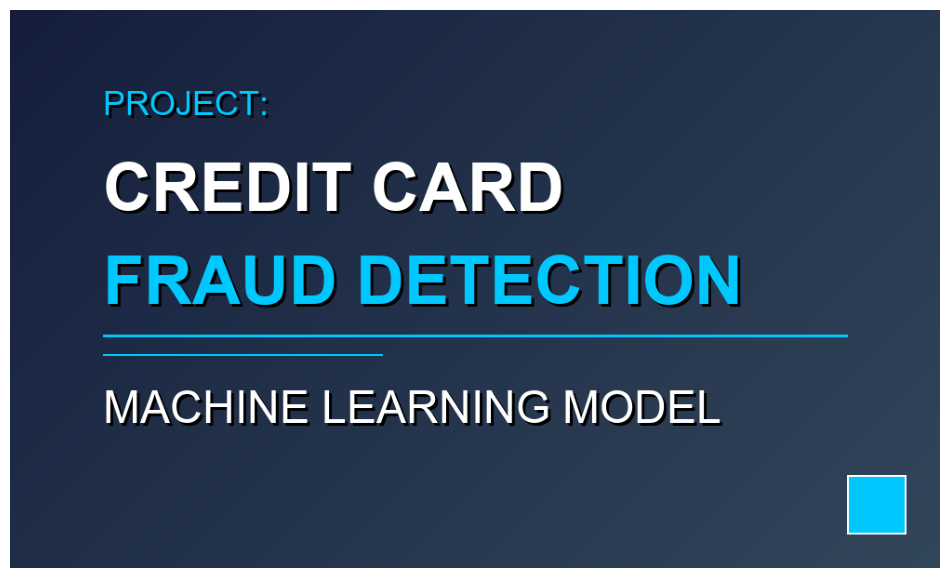

In [124]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import numpy as np

width, height = 1000, 600
bg_color = (20, 30, 60)  
text_color = (255, 255, 255) 
accent_color = (0, 200, 255)  

def create_gradient(width, height, start_color, end_color):
    base = Image.new('RGB', (width, height), start_color)
    top = Image.new('RGB', (width, height), end_color)
    mask = Image.new('L', (width, height))
    mask_data = np.array([[(x + y) / (width + height) * 255 
                         for x in range(width)] for y in range(height)])
    mask = Image.fromarray(mask_data.astype('uint8'))
    base.paste(top, (0, 0), mask)
    return base

image = create_gradient(width, height, bg_color, (50, 70, 90))
draw = ImageDraw.Draw(image)

try:
    font_title = ImageFont.truetype("arialbd.ttf", 72)
    font_subtitle = ImageFont.truetype("arial.ttf", 48)
    font_details = ImageFont.truetype("arial.ttf", 36)
except:
    font_title = ImageFont.load_default()
    font_subtitle = ImageFont.load_default()
    font_details = ImageFont.load_default()

def draw_shadowed_text(draw, text, position, font, fill, shadowcolor=(0,0,0,100)):
    x, y = position
    shadow_position = (x+3, y+3)
    draw.text(shadow_position, text, font=font, fill=shadowcolor)
    draw.text(position, text, font=font, fill=fill)

draw_shadowed_text(draw, "PROJECT:", (100, 80), font_details, accent_color)
draw_shadowed_text(draw, "CREDIT CARD", (100, 150), font_title, text_color)
draw_shadowed_text(draw, "FRAUD DETECTION", (100, 250), font_title, accent_color)
draw_shadowed_text(draw, "MACHINE LEARNING MODEL", (100, 400), font_subtitle, text_color)

draw.line([(100, 350), (900, 350)], fill=accent_color, width=3)
draw.line([(100, 370), (400, 370)], fill=accent_color, width=2)

try:
    from PIL import ImageOps
    icon = Image.new('RGB', (60, 60), accent_color)
    icon = ImageOps.expand(icon, border=2, fill=text_color)
    image.paste(icon, (width-100, height-100))
except:
    pass

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
!pip install torch

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Seed set to {seed}")

In [8]:
df =pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.shape

(284807, 31)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
df_fraud = df[df['Class'] == 1]
df_auth = df[df['Class'] == 0]

print(f'Amount of transactions: {len(df)}')
print(f'Amount of fraudulent transactions: {len(df_fraud)}')
print(f'Proportion of fraudulent transactions: {round(df["Class"].mean() * 100, 4)} %')

Amount of transactions: 284807
Amount of fraudulent transactions: 492
Proportion of fraudulent transactions: 0.1727 %


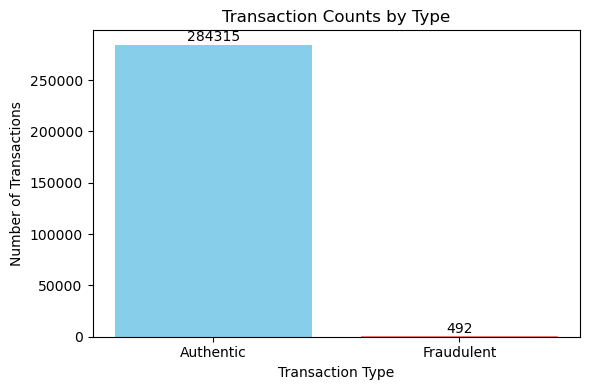

In [13]:
import matplotlib.pyplot as plt

labels = ['Authentic', 'Fraudulent']
counts = [len(df_auth), len(df_fraud)]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['skyblue', 'salmon'])

plt.title('Transaction Counts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')

for i, count in enumerate(counts):
    plt.text(i, count + 500, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


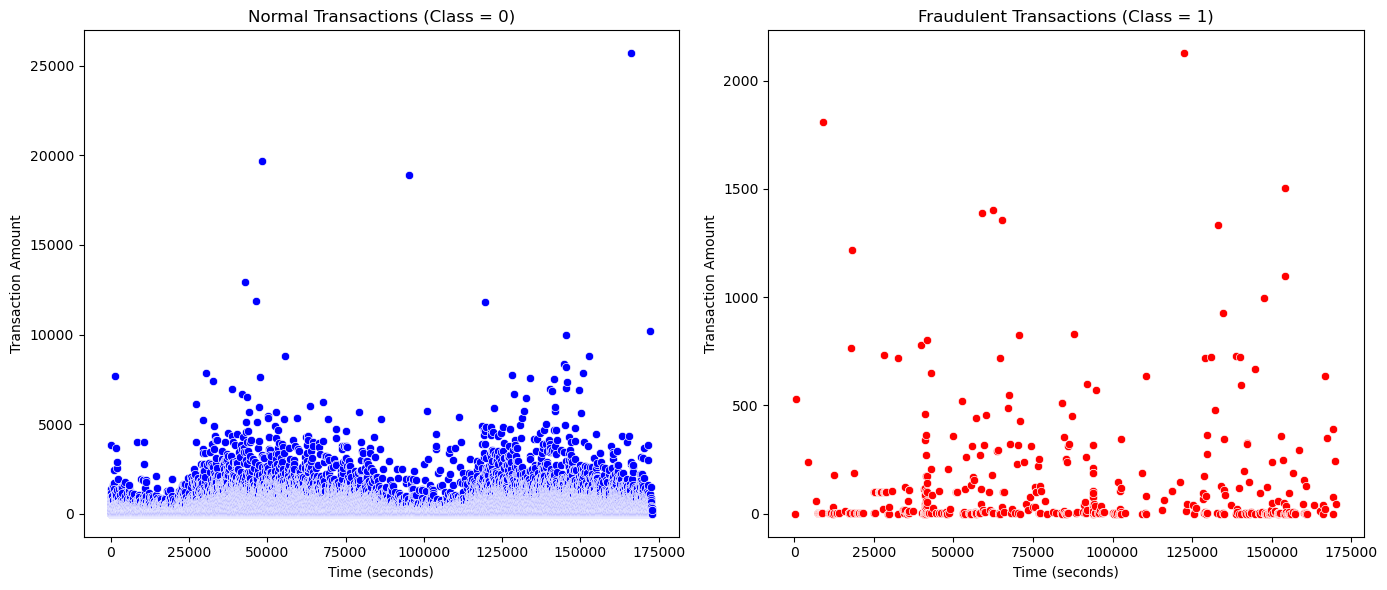

In [14]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_auth, x='Time', y='Amount', color='blue')
plt.title('Normal Transactions (Class = 0)')
plt.xlabel('Time (seconds)')
plt.ylabel('Transaction Amount')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_fraud, x='Time', y='Amount', color='red')
plt.title('Fraudulent Transactions (Class = 1)')
plt.xlabel('Time (seconds)')
plt.ylabel('Transaction Amount')

plt.tight_layout()
plt.show()

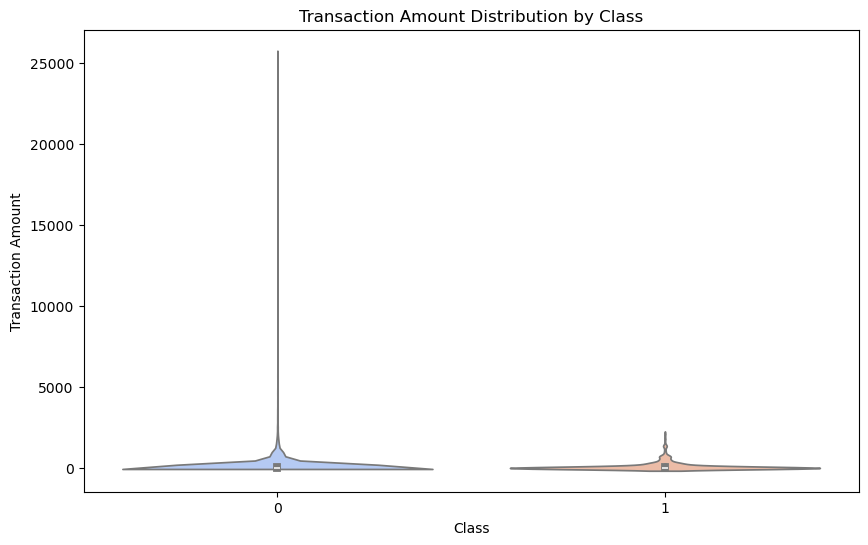

In [15]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Class', y='Amount', palette='coolwarm', scale='width')
plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Transaction Amount')
plt.show()

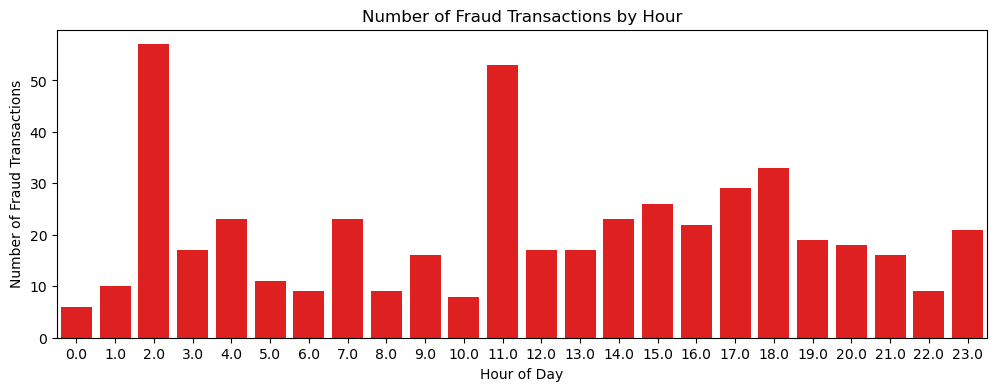

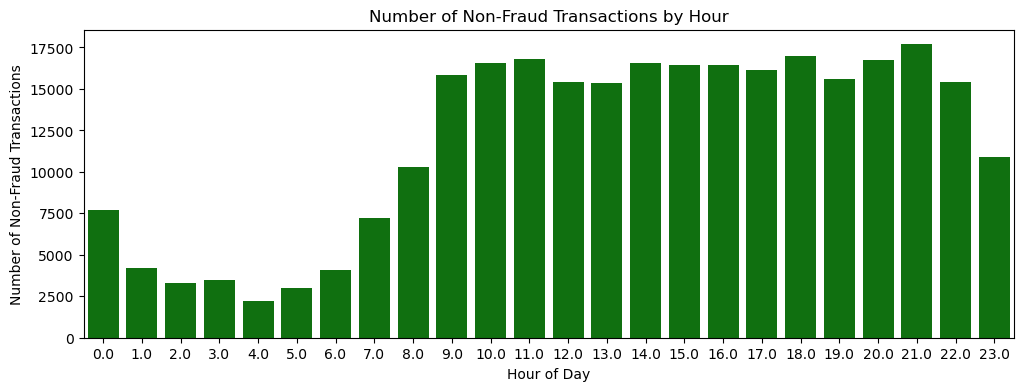

In [16]:
df['Hour'] = (df['Time'] // 3600) % 24

fraud_counts = df[df['Class'] == 1]['Hour'].value_counts().sort_index()
auth_counts = df[df['Class'] == 0]['Hour'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, color='red')
plt.title('Number of Fraud Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(range(0, 24))
plt.show()

plt.figure(figsize=(12, 4))
sns.barplot(x=auth_counts.index, y=auth_counts.values, color='green')
plt.title('Number of Non-Fraud Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Non-Fraud Transactions')
plt.xticks(range(0, 24))
plt.show()

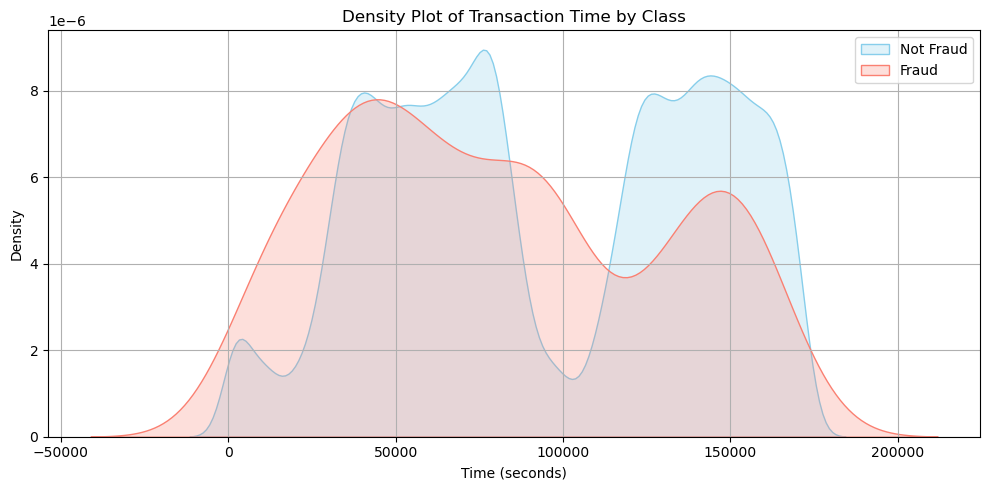

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

sns.kdeplot(data=df[df['Class'] == 0]['Time'], label='Not Fraud', fill=True, color='skyblue')
sns.kdeplot(data=df[df['Class'] == 1]['Time'], label='Fraud', fill=True, color='salmon')

plt.title('Density Plot of Transaction Time by Class')
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

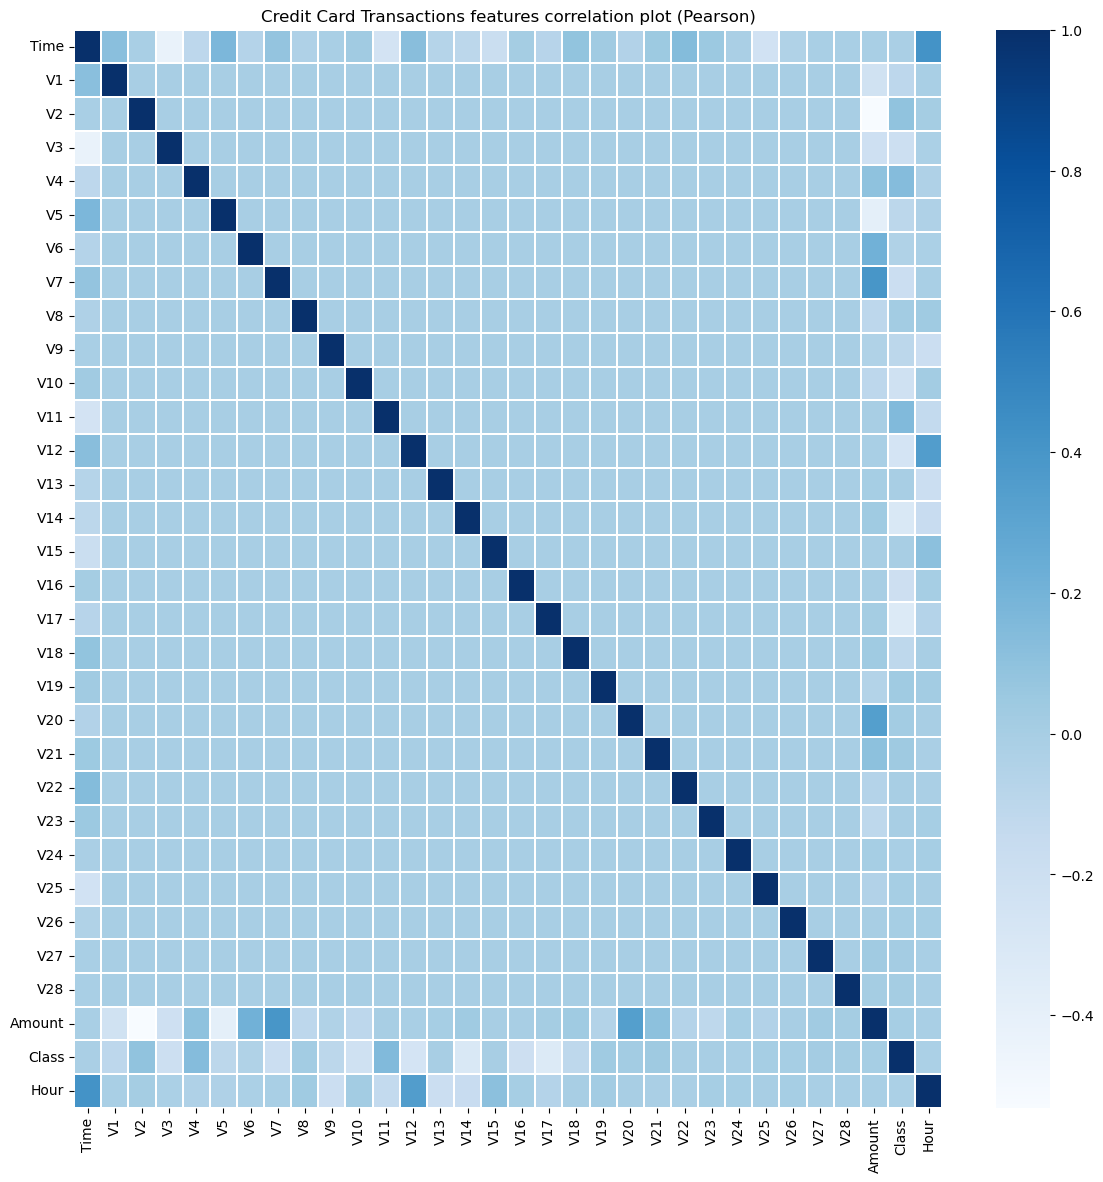

In [91]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Blues")
plt.show()

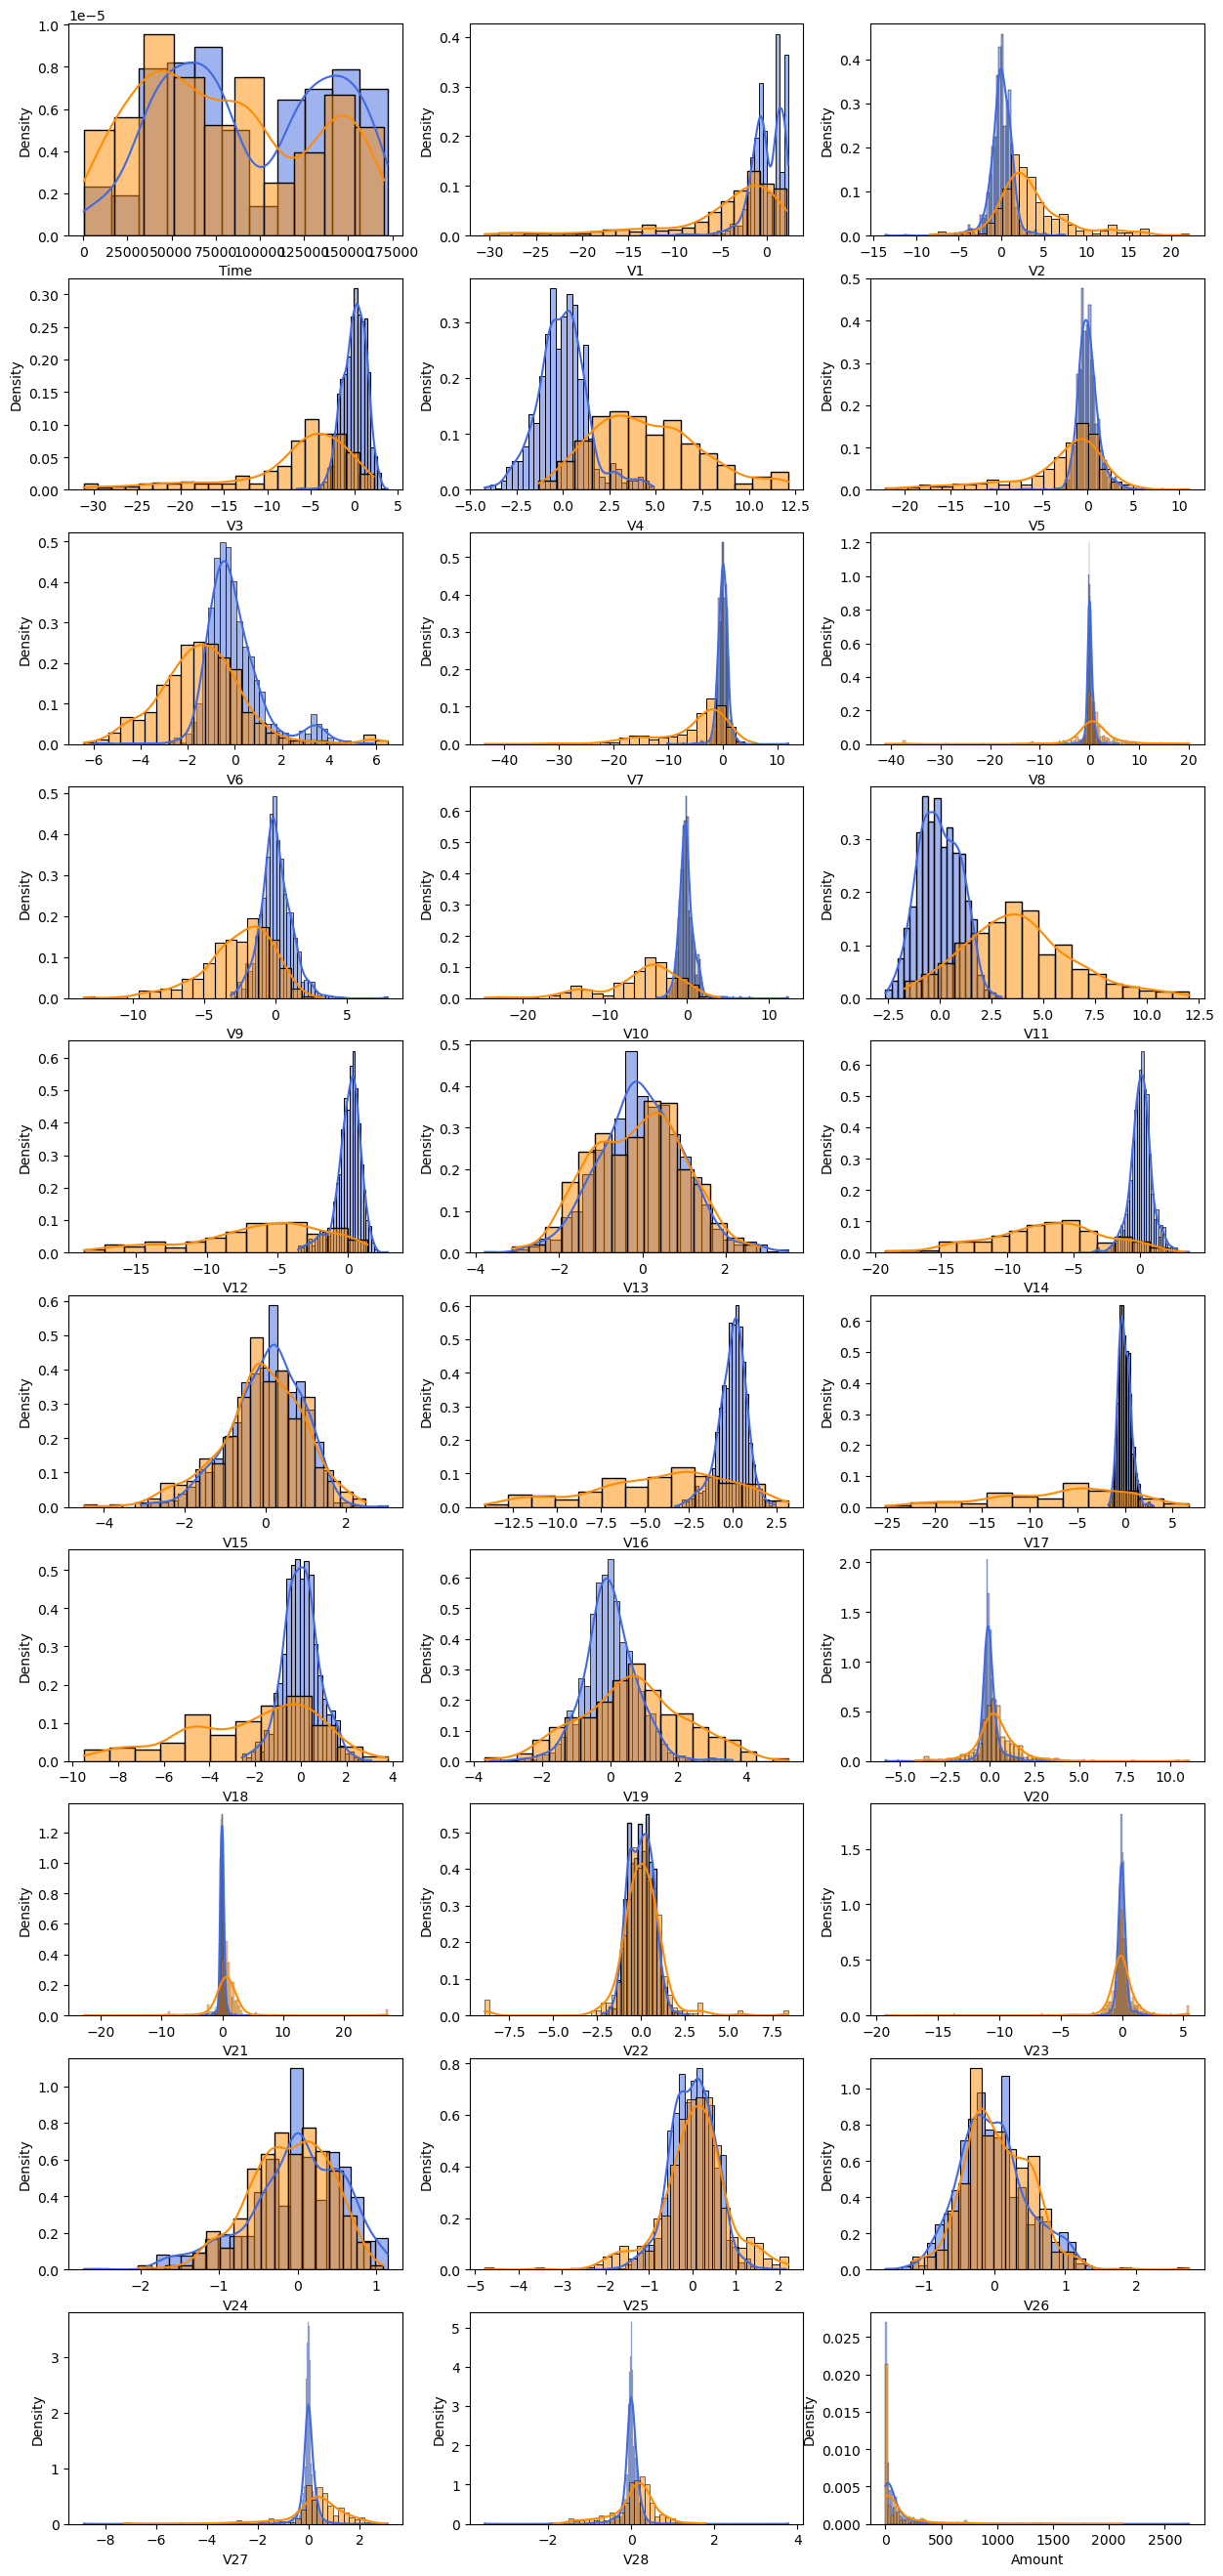

In [18]:
df_auth_plot = df_auth.sample(1000)
features = df.drop(columns='Class', errors='ignore' ).columns
features = [col for col in features if col != 'Hour'] 
fig = plt.figure(figsize=(15, 40))

for i, column in enumerate(features):    
    plt.subplot(12, 3, i+1)
    sns.histplot(data=df_auth_plot, x=column, kde=True, stat='density', color='royalblue')
    sns.histplot(data=df_fraud, x=column, kde=True, stat='density', color='darkorange')
           
plt.show()

In [19]:
selected_features = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

# Building Model

In [20]:
import pandas as pd
import statsmodels.api as sm

features = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']
X = df[features]
y = df['Class']

X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.004179
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               284807
Model:                          Logit   Df Residuals:                   284798
Method:                           MLE   Df Model:                            8
Date:                Thu, 17 Apr 2025   Pseudo R-squ.:                  0.6713
Time:                        13:15:17   Log-Likelihood:                -1190.2
converged:                       True   LL-Null:                       -3621.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2808      0.114    -72.891      0.000      -8.503      -8.058
V3             0.1636      0

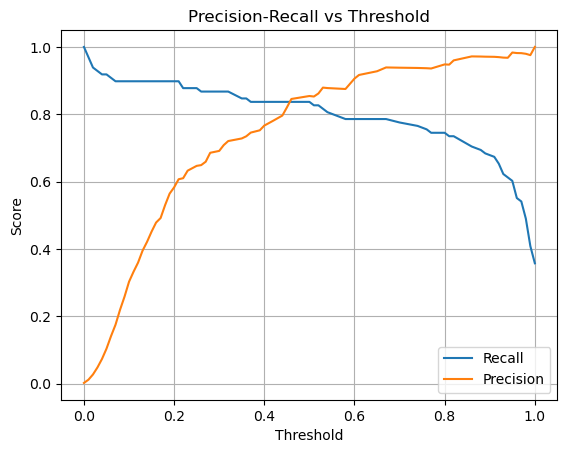

Classification Report (Custom Threshold):
              precision    recall  f1-score   support

           0     0.9998    0.9992    0.9995     56864
           1     0.6466    0.8776    0.7446        98

    accuracy                         0.9990     56962
   macro avg     0.8232    0.9384    0.8720     56962
weighted avg     0.9992    0.9990    0.9990     56962



In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X = df.drop(['Class', 'Time'], axis=1)
y = df['Class'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_res, y_train_res)

y_proba = clf.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

optimal_threshold = 0.25
y_pred_custom = (y_proba >= optimal_threshold).astype(int)

# Báo cáo kết quả
print("Classification Report (Custom Threshold):")
print(classification_report(y_test, y_pred_custom, digits=4))
